### Fetch data

#### Load dependencies

In [2]:
# path variables
import sys
sys.path.insert(0, '/Users/sarfrazahmed/Documents/projects/deposit-model/conf')
from config import SQLQuery

# core libraries
import pandas as pd
import numpy as np
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# plotting libraries
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio
from pandas_profiling import ProfileReport

# setting constants
pio.templates.default = 'plotly_dark'
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
color_map = {'high': '#00cc96', 'low': '#636efa'}

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Fetching Data

In [3]:
querySno = SQLQuery('snowflake')
q = querySno

df_raw = q("""with 

TRANSACTIONS AS -- get all credit transactions
(
    select BUSINESS_ID,
           TRANSACTION_DATE,
           AMOUNT 
  from "PROD_DB"."DATA"."TRANSACTIONS" 
  where type='credit' and status='active'
  group by 1,2,3
),

BUSINESS_DETAIL as -- get all business accounts created between Jan 2021 and Feb 2022
(
  select *
  from "PROD_DB"."DATA"."BUSINESSES"
  where ACCOUNT_CREATE_DATE between '2021-01-01' and '2022-02-28'
),

ALLOY_PERSONS as -- get all the alloy persons data (max of application_versions_id in case of duplicates)
(
  select * from (
select * ,
       row_number() over (partition by APPLICATION_ID order by APPLICATION_VERSION_ID desc) as rank
from "PROD_DB"."DATA"."ALLOY_EVALUATIONS_PERSONS") 
where rank=1
),

APPLICATION_DETAIL as -- get all entries from applications table
(
  select *
  from "PROD_DB"."DATA"."APPLICATIONS"
),

BASE AS -- create base table with business and transactions
(
    select b.BUSINESS_ID,b.APPLICATION_ID,sum(t.amount) as total_credit_amount
    from BUSINESS_DETAIL b 
    inner join TRANSACTIONS t
    on b.BUSINESS_ID=t.BUSINESS_ID
    where DATEDIFF(day, ACCOUNT_CREATE_DATE, TRANSACTION_DATE) between 0 AND 60
    group by 1,2
)

    select * 
    from base
    left join APPLICATION_DETAIL B
    on base.APPLICATION_ID = B.APPLICATION_ID""")

df_raw.shape

(110642, 102)

In [39]:
# 12 months revenue from account creation date
querySno = SQLQuery('snowflake')
q = querySno

df_raw = q("""with 

REV AS -- get all credit transactions
(
    select BUSINESS_ID,
           TRANSACTION_DATE,
           Abs(AMOUNT)*0.0185 as REVENUE 
  from "PROD_DB"."DATA"."TRANSACTIONS" 
  where type='debit' and status='active' and medium='POS Withdrawal'
  group by 1,2,3
),

BUSINESS_DETAIL as -- get all business accounts created between Jan 2021 and May 2022
(
  select *
  from "PROD_DB"."DATA"."BUSINESSES"
  where ACCOUNT_CREATE_DATE between '2021-01-01' and '2021-05-31'
),


APPLICATION_DETAIL as -- get all entries from applications table
(
  select *
  from "PROD_DB"."DATA"."APPLICATIONS"
),

BASE AS -- create base table with business and transactions
(
    select b.BUSINESS_ID,b.APPLICATION_ID,sum(t.REVENUE) as total_revenue
    from BUSINESS_DETAIL b 
    inner join REV t
    on b.BUSINESS_ID=t.BUSINESS_ID
    where DATEDIFF(day, ACCOUNT_CREATE_DATE, TRANSACTION_DATE) between 0 AND 365
    group by 1,2
),

TRANSACTIONS AS -- get all credit transactions
(
    select BUSINESS_ID,
           TRANSACTION_DATE,
           AMOUNT 
  from "PROD_DB"."DATA"."TRANSACTIONS" 
  where type='credit' and status='active'
  group by 1,2,3
),

FINAL_TRANSACTIONS AS 
(
  select b.BUSINESS_ID,b.APPLICATION_ID,sum(t.AMOUNT) as total_credit_amount
    from BUSINESS_DETAIL b 
    inner join TRANSACTIONS t
    on b.BUSINESS_ID=t.BUSINESS_ID
    where DATEDIFF(day, ACCOUNT_CREATE_DATE, TRANSACTION_DATE) between 0 AND 60
    group by 1,2
 )

    select base.*,FINAL_TRANSACTIONS.total_credit_amount,APPLICATION_DETAIL.*
    from base
    inner join FINAL_TRANSACTIONS
    on base.APPLICATION_ID = FINAL_TRANSACTIONS.APPLICATION_ID
    left join APPLICATION_DETAIL
    on base.APPLICATION_ID = APPLICATION_DETAIL.APPLICATION_ID
""")

df_raw.shape

(38501, 103)

#### Add target variable

In [40]:
df = df_raw.copy(deep=True)
df['deposit_class'] = np.where(df['total_credit_amount']<800, 'low', np.where(df['total_credit_amount']>1200, 'high', 'mid'))
df = df[df['deposit_class'] != 'mid']
print(df['deposit_class'].value_counts())
df.shape

high    20616
low     14959
Name: deposit_class, dtype: int64


(35575, 104)

In [41]:
rev_df = pd.read_csv('DEBIT_CARD_REV.csv')
rev_df.head()

,BUSINESS_ID,DEBIT_SPENDS,DEBIT_CARD_REV_12
0,cfcabc5f-8113-4777-affd-3fd7d67c3a44,0.00,0.000000
1,92bc78e9-0eb4-44fa-b90e-cc531abed7e1,-672.13,-12.434405
2,d34b501a-273e-4713-bf17-fd22c6dbcb1a,-5157.33,-95.410605
3,32419ee7-77dd-4e26-9710-6fa9b202cf98,-10590.01,-195.915185
4,4740eaef-1acd-45ea-b4cb-680845cb3f28,-619.18,-11.454830


In [42]:
combined_df = df.merge(rev_df, left_on='business_id', right_on='BUSINESS_ID')
combined_df.shape

(35568, 107)

In [43]:
combined_df['DEBIT_CARD_REV_12'] = np.absolute(combined_df['DEBIT_CARD_REV_12'])
combined_df[['business_id', 'total_revenue', 'DEBIT_CARD_REV_12']].head(20)

,business_id,total_revenue,DEBIT_CARD_REV_12
0,632dabdf-cbe1-4ead-9490-8203a73962e1,573.996910,599.840300
1,2fa392fe-07ac-482e-8381-38d67baa66e8,95.078160,95.078160
2,6c0a8fdf-106f-437f-88f3-d28b16b03ed1,3879.780410,3977.122970
3,d8db34ef-d326-4c8d-ba88-43d46eeaa602,603.195645,603.195645
4,3b3bd5b2-21c6-4bf0-a220-c8db5faca165,8.912560,8.912560
5,55825b37-7ba4-49dd-b887-a2d92ee17a9a,49.690260,49.730405
6,7576a9c7-4b3f-4dae-b9b2-59aeb613e70e,195.999545,221.512710
7,3511affc-2614-4f51-883e-ebca8c8efa38,157.245930,157.359150
8,7f41f531-a0c5-4e3b-a00b-4ce7d6bfd495,11.968390,14.720450
9,16459d92-6911-4f00-bc63-c7677088a22a,232.485615,232.805850


In [44]:
df = combined_df.copy(deep=True)
df.head()

,business_id,application_id,total_revenue,total_credit_amount,application_id,created_datetime,email,current_step,status,percentage_complete,is_email_valid,email_is_verified,purpose_of_another_account,application_start_datetime,application_complete_datetime,account_ready_to_open_datetime,account_opened_datetime,account_denied_datetime,application_resubmitted_datetime,account_denied_description,last_event_name,last_event_description,auto_denied,auto_approved,last_incomplete_datetime,was_incomplete,number_incomplete_events,is_straight_through,application_stale_datetime,application_closed_datetime,aml_risk_score,high_risk_industry,utm_url,utm_term,utm_network,utm_content,utm_campaign,gcl_id,irclickid,utm_timestamp,utm_adcopy,irgwc,sid,gsxid,gspk,hsa_net,hsa_ver,hsa_ad,hsa_grp,hsa_cam,hsa_src,hsa_acc,msclkid,caclid,utm_keyword,segment_user_id,business_pitch,estimated_monthly_revenue,incoming_ach_payments,check_deposit_amount,incoming_wire_transfer,outgoing_ach_and_checks,outgoing_wire_transfers,number_of_employees,purpose_of_account,purpose_of_account_other,has_international_business,international_business_countries,international_transfer_timeframe,international_transfer_amount,legal_name_exist_in_doc,current_bank,hear_about_novo,hear_about_novo_text,industry_id,industry_name,industry_category_name,onboarding_business_id,company_name,state_registered,dba,date_of_establishment,business_type,website,business_address_city,business_address_state,business_address_zip,mailing_address_city,mailing_address_state,mailing_address_zip,gpc_id,gpc_customer_id,gpc_created_at,email_domain,azlo_referral,client_id,identity_bracket,utm_source,utm_medium,application_channel_utm,application_channel,gpc_partner_key,ein_ssn,deposit_class,BUSINESS_ID,DEBIT_SPENDS,DEBIT_CARD_REV_12
0,632dabdf-cbe1-4ead-9490-8203a73962e1,6a700a24-537c-44b1-8944-8b3c34a6f813,573.996910,35899.19,6a700a24-537c-44b1-8944-8b3c34a6f813,2021-04-15 16:23:22.942000+00:00,hello@crackerjck.co,16,account_opened,100.0,true,False,,2021-04-15 16:23:22.949,2021-04-15 18:30:50.796,2021-04-16 14:11:44.689,2021-04-16 14:11:55.733,NaT,NaT,None,account_opened,ACCOUNT OPENED by Admin (Nipunika Reddy),0,0,NaT,0,0,1,NaT,NaT,185.0,false,http://banknovo.com/,small business checking,g,116663643303,12396349563,Cj0KCQjwpdqDBhCSARIsAEUJ0hMKbF6WM-Xj36cjNZPdWm...,None,1618436110621,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,ea930485ee2ba73a70bde5bc8f73593315aff77347d5db...,crackerJCK is a marketing consultancy that foc...,$5K +,$5K +,$1K +,$0,$5K +,$0,2,"[\n ""business expenses"",\n ""accounting"",\n ...",,False,None,,,True,None,None,None,d2440ab9-ddab-4f00-ae93-03c00e1fa884,Marketing Consulting Services,"Professional, Scientific, and Technical Services",355b1265-701f-4310-a738-7ede5b811982,crackerJCK LLC,TX,None,2021-04,LLC,None,Austin,TX,78741,None,None,None,None,None,NaT,crackerjck.co,False,66.214.163.97,Bracket 2,google,cpc,Google,Google,None,0,high,632dabdf-cbe1-4ead-9490-8203a73962e1,-32423.80,599.840300
1,2fa392fe-07ac-482e-8381-38d67baa66e8,84212bdf-9f67-4278-ad8e-8a41305cb1de,95.078160,8815.86,84212bdf-9f67-4278-ad8e-8a41305cb1de,2021-05-16 02:56:53.837000+00:00,empireproperty@consultant.com,16,account_opened,100.0,true,False,Opening a new account for a different business,2021-05-16 02:56:53.843,2021-05-24 03:17:24.888,2021-05-24 07:32:34.358,2021-05-24 07:32:44.087,NaT,NaT,None,account_opened,ACCOUNT OPENED by Admin (Divya Matta),0,0,NaT,0,0,1,NaT,NaT,151.0,false,http://banknovo.com/,online business checking,g,116663643263,12396349563,Cj0KCQjw4v2EBhCtARIsACan3nxn9QEpcX7caNahymQDzO...,None,1621133776417,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,164519237028c602f46a51db6a393f2e16a6a1ba59817f...,Wholesaling Properties. Help distressed seller...,<$1K,$1K +,$1K +,$1K +,$1K +,$1K +,3,"[\n ""business expenses"",\n ""payroll"",\n ""tr...",,False,None,,,True,None,None,None,631e25a6-a8cb-4462-9255-092b43dae848,Lessors of Residential Buildin

#### Deposit Class Distribution

In [45]:
fig = px.histogram(df, 
                   x="deposit_class", 
                   color="deposit_class", 
                   text_auto=True, 
                   color_discrete_map=color_map)
fig.show()

#### Derived variables

In [46]:
# Application Completion Duration
df['application_completion_duration'] = (df['application_complete_datetime'] - df['application_start_datetime']).astype('timedelta64[m]')

# Email Domain
df['email_domain_variable'] = np.where(df['email_domain'].isin(['gmail.com', 'yahoo.com', 'outlook.com', 'icloud.com', 'hotmail.com']), df['email_domain'], 'others')

# Week Number
df['week'] = df['application_start_datetime'].dt.week

# Business Age
df['date_of_establishment_dt'] = pd.to_datetime(df['date_of_establishment'], format='%Y-%m', errors='coerce').dropna()
df['business_age'] = round((df['application_start_datetime'] - df['date_of_establishment_dt']) / np.timedelta64(1, 'Y'),2)
df['business_age'] = df['business_age'].fillna(0)

# Number of Employees
df["number_of_employees"] = pd.to_numeric(df["number_of_employees"])
df['number_of_employees_bin'] = df["number_of_employees"]
df['number_of_employees_bin'] = np.where((df['number_of_employees']>=5) & (df['number_of_employees']<=10), '5-10', 
                                np.where((df['number_of_employees']>10) & (df['number_of_employees']<=20), '11-20', 
                                np.where((df['number_of_employees']>20), '20+', df['number_of_employees_bin'])))

# Website Flag
df['website_flag'] = np.where(df['website'] != df['website'], 'Offline', 'Online')

#### List dependent and independent

In [47]:
dependent_variable = ['deposit_class']
independent_variables = ['business_type',
                         'business_address_state',
                         'email_domain_variable',
                         'application_completion_duration',
                         'application_channel',
                         'estimated_monthly_revenue', 
                         'incoming_ach_payments',
                         'check_deposit_amount',
                         'incoming_wire_transfer',
                         'outgoing_ach_and_checks',
                         'outgoing_wire_transfers',
                         'business_age',
                         'industry_category_name',
                         'number_of_employees_bin',
                         'website_flag',
                         'high_risk_industry',
                         'aml_risk_score']
                        #  'total_credit_amount']
                        #  'total_revenue']

#### Drop null rows

In [48]:
print(df.shape)
df.dropna(subset=independent_variables, inplace=True)
print(df.shape)

(35568, 114)
(35545, 114)


#### Encode categorical variables

In [52]:
for variable in list(df[independent_variables].select_dtypes(include=['object']).columns):
    df[variable]=df[variable].astype('category').cat.codes
df[independent_variables].head()

,business_type,business_address_state,email_domain_variable,application_completion_duration,application_channel,estimated_monthly_revenue,incoming_ach_payments,check_deposit_amount,incoming_wire_transfer,outgoing_ach_and_checks,outgoing_wire_transfers,business_age,industry_category_name,number_of_employees_bin,website_flag,high_risk_industry,aml_risk_score
0,1,45,3,127.0,4,4,4,2,0,4,0,0.04,13,2,0,0,185.0
1,1,44,3,11540.0,4,5,2,2,2,2,2,1.29,15,4,0,0,151.0
2,1,50,3,21.0,4,3,3,5,5,3,5,2.72,16,6,1,0,173.0
3,1,35,0,14.0,0,4,0,4,0,2,2,4.03,8,0,0,0,166.0
4,1,35,0,376.0,11,2,0,2,5,5,5,0.02,15,2,0,0,165.0


#### Train test split

In [25]:
X = df[independent_variables]
y = df[dependent_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(20568, 17)
(82276, 17)
(20568, 1)
(82276, 1)


#### Decision Tree Fit

In [26]:
# clf = tree.DecisionTreeClassifier(max_depth=4, random_state=42)
# clf.fit(X_train.values, y_train.values)

In [27]:
# plt.figure(figsize=(100,50))
# tree.plot_tree(clf,
#                feature_names = X_train.columns, 
#                class_names=y_train['deposit_class'].unique(),
#                rounded=True,
#                filled = True)
# plt.show()

#### XGBoost Fit

In [35]:
model = XGBClassifier()
model.fit(X_train[independent_variables], y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

[14:10:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### Train Report

In [36]:
y_pred = model.predict(X_train[independent_variables].values)

# Confusion Matrix
cmtx = pd.DataFrame(
    confusion_matrix(y_train, y_pred, labels=['high', 'low']), 
    index=['true:high', 'true:low'], 
    columns=['pred:high', 'pred:low']
)
print(cmtx, '\n')

# Accuracy Score
print('Accuracy Score:', accuracy_score(y_train, y_pred), '\n')

# Classification Report
print(classification_report(y_train, y_pred))

           pred:high  pred:low
true:high       7739      2207
true:low        1902      8720 

Accuracy Score: 0.800223648385842 

              precision    recall  f1-score   support

        high       0.80      0.78      0.79      9946
         low       0.80      0.82      0.81     10622

    accuracy                           0.80     20568
   macro avg       0.80      0.80      0.80     20568
weighted avg       0.80      0.80      0.80     20568



#### Test Scores

In [55]:
y_test = df['deposit_class']
y_test

0        high
1        high
2        high
3        high
4         low
         ... 
35563     low
35564     low
35565     low
35566     low
35567     low
Name: deposit_class, Length: 35545, dtype: object

In [56]:
y_pred = model.predict(df[independent_variables].values)

# Confusion Matrix
cmtx = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels=['high', 'low']), 
    index=['true:high', 'true:low'], 
    columns=['pred:high', 'pred:low']
)
print(cmtx, '\n')

# Accuracy Score
print('Accuracy Score:', accuracy_score(y_test, y_pred), '\n')

# Classification Report
print(classification_report(y_test, y_pred))

           pred:high  pred:low
true:high      13160      7442
true:low        4914     10029 

Accuracy Score: 0.6523843015895344 

              precision    recall  f1-score   support

        high       0.73      0.64      0.68     20602
         low       0.57      0.67      0.62     14943

    accuracy                           0.65     35545
   macro avg       0.65      0.65      0.65     35545
weighted avg       0.66      0.65      0.65     35545



#### Median deposit binned by probabilities

In [38]:
def Extract(lst):
    return list(list(zip(*lst))[0])

res = model.predict_proba(X_test.drop(columns=['total_credit_amount'])).tolist()
class_proba = Extract(res)

X_test['class_probability'] = class_proba

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
X_test['binned'] = pd.cut(X_test['class_probability'], bins)

result_df = X_test.groupby('binned', as_index=False)['total_credit_amount'].median()
result_df['binned'] = result_df['binned'].astype('str')
fig = px.line(result_df, x='binned', y='total_credit_amount', markers=True)
fig.show()

KeyError: "['total_credit_amount'] not found in axis"

In [81]:
model.get_booster().get_score(importance_type='gain')

{'business_type': 3.267235040664673,
 'business_address_state': 3.0338330268859863,
 'email_domain_variable': 3.73721981048584,
 'application_completion_duration': 3.0864522457122803,
 'application_channel': 4.023074150085449,
 'estimated_monthly_revenue': 20.93508529663086,
 'incoming_ach_payments': 3.086477041244507,
 'check_deposit_amount': 3.1959176063537598,
 'incoming_wire_transfer': 3.561588764190674,
 'outgoing_ach_and_checks': 4.282107830047607,
 'outgoing_wire_transfers': 3.4910504817962646,
 'business_age': 3.3382973670959473,
 'industry_category_name': 4.383271217346191,
 'number_of_employees_bin': 2.923809766769409,
 'website_flag': 3.076953172683716,
 'high_risk_industry': 3.475210666656494,
 'aml_risk_score': 3.2043256759643555}

<Figure size 7200x3600 with 0 Axes>

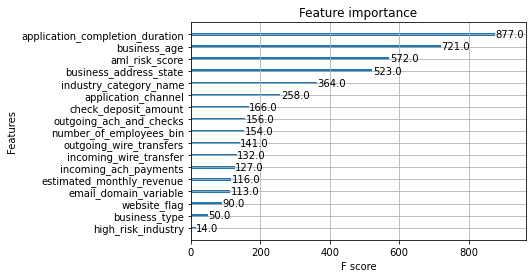

In [83]:
plt.figure(figsize=(100,50))
plot_importance(model)
plt.show()

#### Model Scoring

In [78]:
def Extract(lst):
    return list(list(zip(*lst))[0])

res = model.predict_proba(df[independent_variables]).tolist()
class_proba = Extract(res)

df['class_probability'] = class_proba

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
df['binned'] = pd.cut(df['class_probability'], bins)

credit_df = df.groupby('binned', as_index=False)['total_credit_amount'].mean()
revenue_df = df.groupby('binned', as_index=False)['DEBIT_CARD_REV_12'].mean()
result_df = credit_df.merge(revenue_df, on='binned')
result_df['binned'] = result_df['binned'].astype('str')

In [79]:
result_df

,binned,total_credit_amount,DEBIT_CARD_REV_12
0,"(0.0, 0.1]",1750.204539,59.941781
1,"(0.1, 0.2]",1880.185820,57.724226
2,"(0.2, 0.3]",2508.712615,72.935066
3,"(0.3, 0.4]",3707.123282,95.273851
4,"(0.4, 0.5]",5571.550389,115.260394
5,"(0.5, 0.6]",7368.042591,147.545515
6,"(0.6, 0.7]",10075.920542,171.236608
7,"(0.7, 0.8]",14277.317544,204.962160
8,"(0.8, 0.9]",18505.354659,228.626992
9,"(0.9, 1.0]",21344.358273,297.888462


In [76]:
result_df['count'] = result_df['total_credit_amount']
result_df['volume'] = (result_df['count']/result_df['total_credit_amount'].sum())*100
result_df

,binned,total_credit_amount,DEBIT_CARD_REV_12,count,volume
0,"(0.0, 0.1]",401,401,401,1.128147
1,"(0.1, 0.2]",2172,2172,2172,6.110564
2,"(0.2, 0.3]",4172,4172,4172,11.737234
3,"(0.3, 0.4]",5119,5119,5119,14.401463
4,"(0.4, 0.5]",5607,5607,5607,15.774371
5,"(0.5, 0.6]",5743,5743,5743,16.156984
6,"(0.6, 0.7]",5355,5355,5355,15.065410
7,"(0.7, 0.8]",4079,4079,4079,11.475594
8,"(0.8, 0.9]",2318,2318,2318,6.521311
9,"(0.9, 1.0]",579,579,579,1.628921


In [77]:
fig = px.bar(result_df, x='binned', y='count', text=result_df['volume'].apply(lambda x: '{0:1.2f}%'.format(x)))
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_layout(
    width=1100,
    height=300,
)


In [73]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=result_df['binned'], y=result_df['total_credit_amount'], name='Deposit'), 
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x=result_df['binned'], y=result_df['DEBIT_CARD_REV_12'], name='Revenue', line=dict(color="#ffe476")), 
    secondary_y=True
)

# Add figure title
# fig.update_layout(
#     title_text="Binned Probabilities"
# )

# Set y-axes titles
fig.update_yaxes(title_text="Deposit (in dollars)", secondary_y=False)
fig.update_yaxes(title_text="Revenue (in dollars)", secondary_y=True)

fig.update_layout(
    # color_discrete_map = color_map,
    width=1100,
    height=500
)

fig.show()

In [61]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=result_df['binned'], y=result_df['total_credit_amount'], name='Deposit'), 
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x=result_df['binned'], y=result_df['DEBIT_CARD_REV_12'], name='Revenue', line=dict(color="#ffe476")), 
    secondary_y=True
)

# Add figure title
# fig.update_layout(
#     title_text="Binned Probabilities"
# )

# Set y-axes titles
fig.update_yaxes(title_text="Deposit (in dollars)", secondary_y=False)
fig.update_yaxes(title_text="Revenue (in dollars)", secondary_y=True)

fig.update_layout(
    # color_discrete_map = color_map,
    width=1100,
    height=500
)

fig.show()

In [62]:
result_df

,binned,total_credit_amount,DEBIT_CARD_REV_12
0,"(0.0, 0.1]",257.250,14.354520
1,"(0.1, 0.2]",385.030,14.025960
2,"(0.2, 0.3]",455.985,16.274727
3,"(0.3, 0.4]",611.140,23.341635
4,"(0.4, 0.5]",1434.050,30.294860
5,"(0.5, 0.6]",2239.290,44.273830
6,"(0.6, 0.7]",3459.630,55.876845
7,"(0.7, 0.8]",5287.500,71.782775
8,"(0.8, 0.9]",7869.735,86.023983
9,"(0.9, 1.0]",11601.060,105.729165


In [80]:
df.columns

Index(['business_id', 'application_id', 'total_revenue', 'total_credit_amount',
       'application_id', 'created_datetime', 'email', 'current_step', 'status',
       'percentage_complete',
       ...
       'DEBIT_CARD_REV_12', 'application_completion_duration',
       'email_domain_variable', 'week', 'date_of_establishment_dt',
       'business_age', 'number_of_employees_bin', 'website_flag',
       'class_probability', 'binned'],
      dtype='object', length=116)

In [83]:
result_df.corr()

,total_credit_amount,DEBIT_CARD_REV_12
total_credit_amount,1.000000,0.987155
DEBIT_CARD_REV_12,0.987155,1.000000
